
# ConvNN Overfitting FlowersDataset

In this notebook we see a more complex example of ConvNN. 

In addition, we discuss about overfitting, and possible ways for reducing it (particulary suitable with ConvNNs).

We use a google dataset, containing colored images about flowers. $3670$ colored photos about flowers, with $5$ different classes: daisy, dandelion, roses, sunflowers, tulips.

## IMPORTING LIBRARIES

We import the basic libraries.

In [43]:
import tensorflow as tf  # For downloading and loading the dataset

import matplotlib.pyplot as plt

import numpy as np

## LOAD THE DATASET

Let us load the flowers dataset. This time, the downloading and loading of the dataset is a little bit more tricky.

### Download the dataset

We download the dataset from google: link https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz. It is a compressed tgz file.

We use an utility function of tensorflow (i.e. keras) for downloading it.

In [2]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

Path of dataset in the file system. 

In [3]:
# Location of the dataset in the file system 
data_dir

'C:\\Users\\pitti\\.keras\\datasets\\flower_photos'

This is a Unix-like path. We need to transform it into a Windows path.

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/pitti/.keras/datasets/flower_photos')

`'C:/Users/pitti/.keras/datasets/flower_photos'` is a folder, containing $3670$ colored photos of flowers. The folder contains five sub-directories, one per class:

```
flower_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

### Load the dataset

Now we want to load the dataset from the local storage into a Python object. In particular, into a `tf.data.Dataset`.

For doing so, we use another TensorFlow (i.e. Keras) utility function: `image_dataset_from_directory`.

This utility function not only loads the dataset from a file system folder, but it also splits into into training-validation.

For using this function, we need to specify:
- The spatial dimensions of the images. In this case, we use $w=180,h=180$.
- The seed for doing the random splitting training-validation.
- The percentage of instances in the validation set.

We also need to specify the size of each batch, i.e. the `batch_size`. Why is that? Basically, we already divide the dataset into batches, with the specified size. Batch dimension.

In [5]:
w, h = 180, 180
seed = 42
validation_split=0.2

batch_size = 32

# Loading the training set: train_ds
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset='training',  # We want the training set
  seed=seed,
  image_size=(w, h),
  batch_size=batch_size)

# Loading the validation set: validation_ds
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset='validation',  # We want the validation set
  seed=seed,
  image_size=(w, h),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


`train_ds` is the training dataset. It is a `tf.data.Dataset` object. It contains both the instances and the labels. It contains both `x_train` and `y_train`. 

`validation_ds` is the training dataset. It is a `tf.data.Dataset` object. It contains both the instances and the labels. It contains both `x_val` and `y_val`. 

As it can be seen, there are $2936$ instances in the training set, and $734$ in the validation set.

We can inspect the names of the classes.

In [6]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
class_names = train_ds.class_names

### `tf.data.Dataset`

`train_ds` and `validation_ds` are both instances of the class `tf.data.Dataset`. We use `train_ds` for explaining a little bit this class.

`train_ds` is basically a sequence (i.e. list) over the different batches. Since the training set contains $2936$ instances, and each batch contains $32$ instances, there are $2936 / 32 = 92$ batches. So, `train_ds` contains $92$ elements.

In [7]:
len(train_ds)

92

**Batch**

Each batch contains $32$ instances. 

More precisely, each batch is a pair `x_batch, y_batch`: `x_batch` contains the $32$ instances, which are colored images; `y_batch` contains the labels. Basically, the pair `x_batch, y_batch` is the pair instances-labels.

The instances in `x_batch` are colored images, with spatial dimensions $180*180$. So, basically the dimensions of each instance are $180, 180, 3$. The last dimension is the channels dimension: $3$ channels related to the three colors. On the whole, `x_batch` has size $32, 180, 180, 3$.

Instead, `y_batch` is a flat vector. Size $32$.

As example, let's take the first batch from `train_ds`.

For taking the first element (i.e. the first batch) we can't simply do `train_ds[0]`. Because a `tf.data.Dataset` is iterable, but not subscriptable. A way fro taking the first element is by using the Iterator/Iterable pattern: `next(iter(train_ds))`.

In [8]:
batch = next(iter(train_ds))

Let's extract `x_batch, y_batch` from that batch.

In [9]:
x_batch, y_batch = batch

print(x_batch.shape)

print(y_batch.shape)

(32, 180, 180, 3)
(32,)


**`x_batch, y_batch`**

`x_batch` is basically a list of $32$ elements over the different instances, which are colored images with dimensions $180,180,3$. `y_batch` is a list of $32$ elements over the labels.

In [10]:
# First instance. Colored image.
instance = x_batch[0]

# Label of the first instance.
label = y_batch[0]

### Visualizing an image

So, now we know how can we visualize an image from the dataset.

Let's visualize the first image from the training set `train_ds`.

In [11]:
batch = next(iter(train_ds))
x_batch, y_batch = batch

Label: tf.Tensor(1, shape=(), dtype=int32)
Class name: dandelion


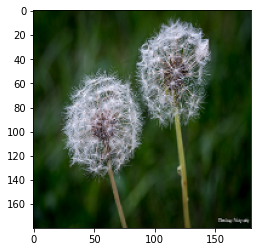

In [14]:
instance = x_batch[0]  # Colored image 
label = y_batch[0]  # Label (natural number, i.e. index)

# Name of that class/label
class_name = class_names[label]

plt.imshow(instance.numpy().astype("uint8"))

print('Label:', label)
print('Class name:', class_name)

Let's visualize $9$ images from the first batch. Method `take` of `tf.data.Dataset`: it returns a sub-dataset containing only the first batch.

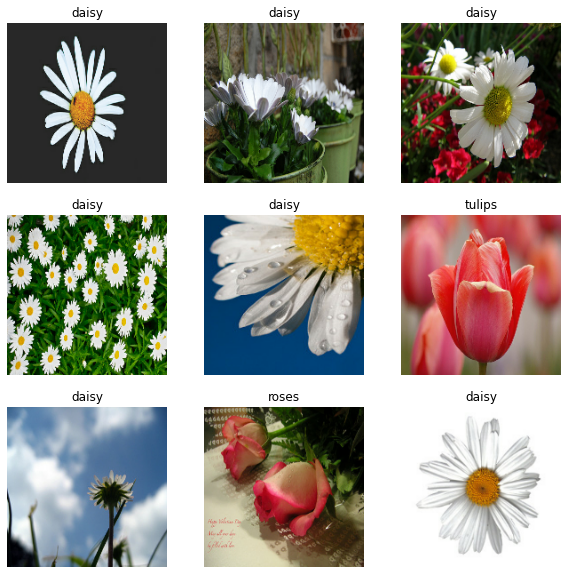

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## PRE-PROCESSING

Some pre-processing operations must be performed.

### 1) Normalization of the input data `x`

The values in `x` (both `x_train` and `x_test`) are in the range $[0,255]$. We want to normalize these values into the range $[0,1]$. Remapping the values into the range $[0,1]$.

We perform this Normalization using a layer of the NN, which will be put right after the Input layer. `Rescaling` layer.

### 2) Adding the channels dimension to the input data `x`

Actually, this is not nedded, There is already the channels dimension, because the instances are colored images. They have $3$ channels, related to the $3$ colors.

So, each instance has already three dimensions: spatial dimensions $w=180,h=180$ and channels dimensions $c=3$.

### 3) Transforming `y` into the categorical distribution

Actually, we will use the `sparse_categorical_crossentropy` instead of the `categorical_crossentropy`. Therefore, we dont' need to transform the target vector `y`, neither the training `y_train` nor the test `y_test`. We can use directly the integer labels as they are.

**BASICALLY, NO PRE-PROCESSING OPERATION HAS BEEN PERFORMED!!! WE GIVE TO OUR NN THE "RAW" INPUT. THE "RAW" INSTANCES.**

## MAX POOLING LAYER

### MaxPooling layer

The MaxPooling layer is a layer specific for Convolutional NN. It is a layer that is put into the Convolutional part of the NN, between the convolutional layers.

The aim of the MaxPooling layer is to reduce the spatial dimensions of the input. So, the output spatial dimensions of the MaxPooling layer is smaller than the input spatial dimensions. 

So, for reducing the spatial dimensions of the input, we have seen so far two techniques: using a convolutional layer with non-unitary stride; using a MaxPooling layer.

The MaxPooling layer was more used in the past. Now is becoming less used.

**Input**

The input has a structure, like the input of a normal convolutional layer. Input with dimensions $w_{in}, h_{in}, c_{in}$. $c_{in}$ input channels, with spatial dimensions $w_{in},h_{in}$.

**kernel**

It is defined a single kernel, with spatial dimensions $k_1,k_2$ (they are hyperparameters of the NN). This kernel is a 2D kernel: no channels dimension.

N.B. Actually, the kernel is called **pool**.

**Output**

The output has as many channels as the input: $c_{in}$ channels. So, dimensions of the output are $w_{out},h_{out},c_{out}$.

The spatial dimensions of the output are much smaller than the spatial dimensions of the input.

**Application of the kernel**

For each input channel independently, the 2D kernel is applied. Let's see the application onto a specific input channel.

Input channel/image. Kernel. The kernel is applied across the spatial dimensions of the input image, like a normal kernel. However, the computation in different. All the input values captured by the kernel are compared between one another, and only the maximum value is kept: this is the value for the corresponding output pixel. 

MaxPooling: the neighborhood input values are compared, and only the max value is kept. 

*There is also the AveragePooling layer, which computes the average between the neighborhood input values*.

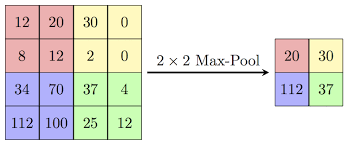

**Output spatial dimensions**

The output spatial dimensions can be easily computed as $w_{out} = \frac{w_{in}}{k_1}$ and $h_{out} = \frac{h_{in}}{k_2}$.

**No parameters**

It is important to notice that a MaxPooling layer does not have parameters.

### General structure of a Conv NN with MaxPooling layers

A Conv NN with MaxPooling layers has still the same general structure.
1. Input layer
2. Convolutional part
3. Flattening
4. Dense part

The difference is that now there are MaxPooling layers inserted in the Convolutional part, interleaved with the convolutional layers.

**Conv part: decreasing of the spatial dimensions and increasing of the channels dimensions**

As we know, typically the Conv part of the NN  follows the approach consisting in gradually decreasing the spatial dimensions $w,h$ and (proportionally) increasing the channels dimension $c$. The decreasing of the spatial dimensions can be done either in two ways: using a non-unitary stride; using MaxPooling layers.

*(As said before, the aim of the MaxPooling layers is to reduce the spatial dimensions.)*

Let's see the approach fro decreasing the spatial dimensions and increasing the channels dimension using MaxPooling layers.

The MaxPooling layers are interleaved with the Convolutional layers.
- Each Convolutional layer (typically) does not change the spatial dimensions. Basically, input spatial dimensions and output spatial dimensions are the same. $w_{in}=w_{out}$, $h_{in}=h_{out}$. (For doing this, the stride must be unitary $S_1=1,S_2=1$ and the padding mode must be `'same'`). However, the channels dimension are increased. The output channels dimenssion is bigger than the input channels dimension: $c_{out}>c_{in}$.
- Each MaxPooling layer decreases the spatial dimensions. Instead, the number of channels is not touched.

So, the Convolutional layers increase the channels dimension, while the MaxPooling layers decrease the spatial dimensions.

Typically, the increasing/decreasing is done with a rate of $2$. Each Convolutional layer doubles the number of channels. Each MaxPooling halves the spatial dimensions (by defining a kernel with spatial dimensions $k_1=2, k_2=2$).

**Comment**

So, we have seen two possible approaches for decreasing the spatial dimensions: using non-unitary strides; using MaxPooling layers. Actually, these two approaches can be also used together.

## CONVOLUTIONAL NN

So, let's define the Coonvolutional NN.

We will use two additional layers this time: the `Rescaling layer` and the `MaxPooling2D` layer.

The aim of `Rescaling layer` is simply to rescale the values of the input instances into the range $[0,1]$. 

The aim of `MaxPooling2D` has just been described.

In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.models import Model

### Define the NN

Let's define a simple Convolutional NN, with the following layers.

**1 Input layer**. Each instance has dimension $w=180,h=180,c=3$.

**2 Rescaling layer**. Input dimensions $w_{in}=180,h_{in}=180,c_{in}=3$, with scale of values $[0,255]$. Output dimensions $w_{in}=180,h_{in}=180,c_{in}=3$, with scale of values $[0,1]$.

**3 First Conv layer**. Input dimensions $w_{in}=180,h_{in}=180,c_{in}=3$. Number of kernels $c_{out}=16$. Kernel spatial dimensions $k_1=3,k_2=3$  (Kernel dimensions $k_1=3,k_2=3,c_{in}=3$). Default strides $S_1=1,S_2=1$ (unitary). Padding mode: `'same'`. 

Output spatial dimensions of the layer are $w_{out}= (w_{in}) / (S_1) = 180$ and $h_{out}= (h_{in}-k_2) / (S_2) = 180$. Output dimensions: $w_{out}=180, h_{out}=180, c_{out}=16$.

**4 First MaxPooling layer**. Input dimensions $w_{in}=180,h_{in}=180,c_{in}=16$. Kernel spatial dimensions $k_1=2,k_2=2$. Output dimensions: $w_{out}=90, h_{out}=90, c_{out}=16$.  

**5 Second Conv layer**. Input dimensions $w_{in}=90,h_{in}=90,c_{in}=16$. Number of kernels $c_{out}=32$. Kernel spatial dimensions $k_1=3,k_2=3$  (Kernel dimensions $k_1=3,k_2=3,c_{in}=16$). Default strides $S_1=1,S_2=1$ (unitary). Padding mode: `'same'`. 

Output spatial dimensions of the layer are $w_{out}= (w_{in}) / (S_1) = 90$ and $h_{out}= (h_{in}-k_2) / (S_2) = 90$. Output dimensions: $w_{out}=90, h_{out}=90, c_{out}=32$.

**6 Second MaxPooling layer**. Input dimensions $w_{in}=90,h_{in}=90,c_{in}=32$. Kernel spatial dimensions $k_1=2,k_2=2$. Output dimensions: $w_{out}=45, h_{out}=45, c_{out}=32$.

**7 Third Conv layer**. Input dimensions $w_{in}=45,h_{in}=45,c_{in}=32$. Number of kernels $c_{out}=64$. Kernel spatial dimensions $k_1=3,k_2=3$  (Kernel dimensions $k_1=3,k_2=3,c_{in}=32$). Default strides $S_1=1,S_2=1$ (unitary). Padding mode: `'same'`. 

Output spatial dimensions of the layer are $w_{out}= (w_{in}) / (S_1) = 45$ and $h_{out}= (h_{in}-k_2) / (S_2) = 45$. Output dimensions: $w_{out}=45, h_{out}=45, c_{out}=64$.

**8 Third MaxPooling layer**. Input dimensions $w_{in}=45,h_{in}=45,c_{in}=64$. Kernel spatial dimensions $k_1=2,k_2=2$. Output dimensions: $w_{out}=22, h_{out}=22, c_{out}=64$.

**9 Flatten layer**. Input dimensions $w_{in}=45,h_{in}=45,c_{in}=64$. Output dimensions $w_{in}*h_{in}*c_{in}=30976$.

**10 Dense layer**. Input dimension $D_{in}=30976$ (i.e. input neurons). Output dimension $D_{out}=128$ (i.e. output neurons). Relu activation function.

**11 Output layer**. Input dimension $D_{in}=128$ (i.e. input neurons). Output dimension $D_{out}=5$ (i.e. output neurons). The number of outputs is equal to the number of different classes. Softmax activation function.

In addition, we use the relu activation function in each Convolutional layer.

In [17]:
xin = Input(shape=(180,180,3))

x = Rescaling(1./255)(xin)

x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = Dense(units=128, activation='relu')(x)
res = Dense(units=5)(x)  # No softmax activation function

model = Model(xin, res)

Actually, as it can been noticed, no activation function has been specified to the output layer. This because we will use `SparseCategoricalCrossentropy` with `from_logits=True`.

### Summary

Let's have a look at the summary

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                         

For each layer, the output dimensions are shown (the first dimension is the batch dimension). In addition, also the number of parameters is shown.

The output dimensions of each layer have already been described. Let's instead focus on the number of parameters of each layer.

1. Input layer. No parameters.

2. Rescaling layer. No parameters.

3. First Conv layer. Number of parameters for each kernel: $k_1*k_2*c_{in}+1 = 3*3*3+1 = 28$ (there is also the bias). There are $c_{out}=16$ kernels: $16*28 = 448$.

4. First MaxPooling layer. No parameters.

5. Second Conv layer. Number of parameters for each kernel: $k_1*k_2*c_{in}+1 = 3*3*16+1 = 145$ (there is also the bias). There are $c_{out}=32$ kernels: $32*145 = 4640$.

6. Second MaxPooling layer. No parameters.

7. Third Conv layer. Number of parameters for each kernel: $k_1*k_2*c_{in}+1 = 3*3*32+1 = 289$ (there is also the bias). There are $c_{out}=64$ kernels: $64*289 = 18496$.

8. Third MaxPooling layer. No parameters.

4. Flatten layer. No parameters.

5. Dense layer. Number of parameters for each output neuron: $D_{in}+1 = 30977$. There are $D_{out}=128$ output neurons. So, total number of parameters: $128*30977=3965056$.

5. Output Dense layer. Number of parameters for each output neuron: $D_{in}+1 = 128$. There are $D_{out}=5$ output neurons. So, total number of parameters: $5*128=645$.

It can be seen that, in the Conv part of the NN: the spatial dimensions are gradually decreased, using the MaxPooling layers;  while the channels dimension is gradually (and proportionally) increased, using the Convolutional layers.

Let's see the output dimensions of each layer in the Conv part.

- Input layer $(180, 180, 3)$
- First Conv layer $(180, 180, 16)$
- First MAxPooling layer $(90, 90, 16)$
- Second Conv layer $(90, 90, 32)$
- Second MAxPooling layer $(45, 45, 32)$
- Third Conv layer $(45, 45, 64)$
- Third MAxPooling layer $(22, 22, 64)$

As it can be seen, the spatial dimensions are halved in each MAxPooling layer, while the channels dimension is doubled in each Convolutional layer.

### Compile the model

Using a last layer with a `softmax` activation and `SparseCategoricalCrossentropy(from_logits = False)` is theoretically equivalent to omit the activation function and set `from_logits = True`. 
This, though, in tensorflow is not always true and it is always better to exploit the `from_logits` parameter, [here](https://stackoverflow.com/questions/61233425/what-should-i-use-as-target-vector-when-i-use-binarycrossentropyfrom-logits-tru/61237426#61237426) you can find some reasons why.

In [19]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

### Train the model

Training. We pass `train_ds` as training set, `validation_ds` as validationset. 

We don't need to specify the batch size, since the dataset is arleady divided into batches.

The number of epochs is $10$.

In [20]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
92/92 [==============================] - 33s 357ms/step - loss: 1.4634 - accuracy: 0.3845 - val_loss: 1.1113 - val_accuracy: 0.5422
Epoch 2/10
92/92 [==============================] - 31s 333ms/step - loss: 1.0210 - accuracy: 0.5865 - val_loss: 0.9673 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 31s 333ms/step - loss: 0.8667 - accuracy: 0.6659 - val_loss: 0.9858 - val_accuracy: 0.6076
Epoch 4/10
92/92 [==============================] - 32s 346ms/step - loss: 0.6742 - accuracy: 0.7347 - val_loss: 1.0224 - val_accuracy: 0.6376
Epoch 5/10
92/92 [==============================] - 33s 360ms/step - loss: 0.4736 - accuracy: 0.8243 - val_loss: 1.0451 - val_accuracy: 0.6444
Epoch 6/10
92/92 [==============================] - 32s 348ms/step - loss: 0.3099 - accuracy: 0.8917 - val_loss: 1.2342 - val_accuracy: 0.6335
Epoch 7/10
92/92 [==============================] - 32s 342ms/step - loss: 0.1986 - accuracy: 0.9370 - val_loss: 1.3873 - val_accuracy: 0.6294

It seems that we have pretty good results on the training set, but not so good results in the validation set.

### Analysis of the results

Function which takes in input the training history object (returned by the `fit` method) and it prints the plots about the loss function and the accuracy,on both training and validation set, with respect to the number of epochs.

In [21]:
def plot_history(training_history, n_epochs):
    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

    plt.figure()
    plt.plot(epochs, training_history.history['accuracy'], label='train_accuracy')
    plt.plot(epochs, training_history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Accuracy')

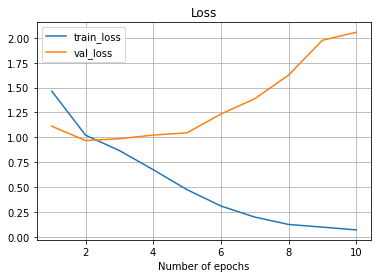

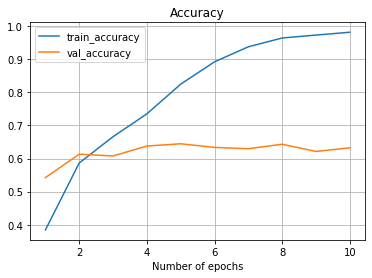

In [22]:
plot_history(history, n_epochs=10)

We can see that the validation score (either loss or accuracy) has a very oscillating trend. In addition, it tends to become worse (biggest number of epochs, i.e. biggest complexity of the NN) with respect to using a smaller number of epochs. 

This means that there is **overfitting**!!! The model is too complex. **A LOT OF OVERFITTING!**

## REDUCING THE OVERFITTING

We have already seen several techniques for reducing overfitting. Here we will use three different techniques altogether:
- Data augmentation (new)
- Early stopping (already seen)
- Drop out (already seen)

There are typically very effective techniques for reducing overfitting when working with images.

### Data augmentation

Data augmentation is a general technique for trying to reduce the overfitting of a ML model. It consists in enlarging the training set by addying new instances, syntetized from the existing ones: basically, they are new fake instances, but generated from the actual ones, so they should be valid instances.

This approach is particular used with images, because it is easier to generate new fake images which are valid.

Indeed, given an actual image, we can generate new fake images by randomly flipping, zoomming, rotating it.  Basically, they are different versions of the same image. 

This helps the NN to extract the interesting pattern from the images, independently from the specific image.

**Keras implementation**

This is implemented in Keras in a particular (smart) way. Basically, Each random operation on the image (e.g. flipping, zooming, rotating) is implemented using a NN layer. Let's explain this by focusing on the flipping operation: `RandomFlip` layer.

The `RandomFlip` layer is put right after the input layer. When an instance goes through this layer, it is randomly flipped. This for each instance given in input to the NN.

How is this data augmentation? Let's consider the training phase. We know that, in each epoch, all the instances of the training set are given to the NN, one at a time (epoch = full pass over the full training set).  So, in each epoch, the same instance is randomly flipped. This means that, in each epoch, a slightly different version of the same image is given in input to the NN.

As said before, this helps the NN to extract the interesting pattern from the images, independently from the specific image.

Layers: `RandomFlip`, `RandomRotation`, `RandomZoom`.

In [23]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

These three layers are typically applied ins equence.

Let's applying these layers into a single image, for visualizing the effects.

So, first of all we define the layers. Basically, a small NN which only performs random flips, rotations, zooms.

In [24]:
image_transformer = tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=(180,180,3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

*USING FUNCTIONAL API: TODO*

In [64]:
def image_transformer_1(instance):
    x = RandomFlip("horizontal", input_shape=(180,180,3))(instance)
    x = RandomRotation(0.9, input_shape=(180,180,3))(x)
    x = RandomZoom(0.9, input_shape=(180,180,3))(x)
    return x

Normal image.

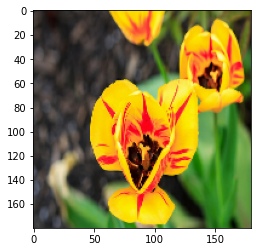

In [108]:
batch = next(iter(train_ds))
x_batch, y_batch = batch
instance = x_batch[0]  # Colored image 
plt.imshow(instance.numpy().astype("uint8"))

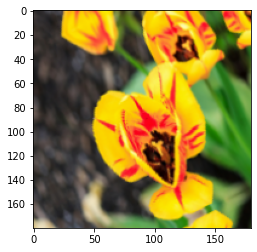

In [111]:
transformed_x_batch = image_transformer(x_batch)

transformed_instance = transformed_x_batch[0]  # Transformed image 

plt.imshow(transformed_instance.numpy().astype("uint8"))

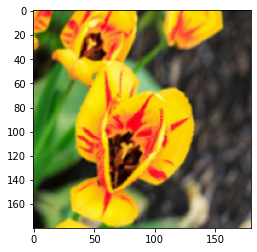

In [112]:
transformed_x_batch = image_transformer(x_batch)

transformed_instance = transformed_x_batch[0]  # Transformed image 

plt.imshow(transformed_instance.numpy().astype("uint8"))

### Early stopping

We have already seen this technique. 

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
callback = EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=3, restore_best_weights=True)

### Dropout

We have already seen also this technique.

In [27]:
from tensorflow.keras.layers import Dropout

We add the DropOut layer right after the last MaxPooling layer. In this way, the DopOut technique is applied on that layer.

### New Conv NN, with data augmentation, early stopping and DropOut

In [28]:
xin = Input(shape=(180,180,3))

x = Rescaling(1./255)(xin)

# DATA AUGMENTATION
x = RandomFlip("horizontal", input_shape=(180,180,3))(x)
x = RandomRotation(0.1, input_shape=(180,180,3))(x)
x = RandomZoom(0.1, input_shape=(180,180,3))(x)

x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# DROP OUT
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(units=128, activation='relu')(x)
res = Dense(units=5)(x)

model = Model(xin, res)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                           

**Compiling the NN.**

In [30]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

**Training the NN.**

We pass the early stopping callback. (So, we can specify a bigger number of epochs).

In [31]:
history = model.fit(train_ds, epochs=15, validation_data=validation_ds, callbacks=[callback])

Epoch 1/15
92/92 [==============================] - 38s 409ms/step - loss: 1.2806 - accuracy: 0.4615 - val_loss: 1.0524 - val_accuracy: 0.5708
Epoch 2/15
92/92 [==============================] - 37s 403ms/step - loss: 0.9987 - accuracy: 0.6073 - val_loss: 0.9765 - val_accuracy: 0.6267
Epoch 3/15
92/92 [==============================] - 37s 398ms/step - loss: 0.9063 - accuracy: 0.6434 - val_loss: 0.9444 - val_accuracy: 0.6485
Epoch 4/15
92/92 [==============================] - 37s 395ms/step - loss: 0.8449 - accuracy: 0.6788 - val_loss: 0.8110 - val_accuracy: 0.6935
Epoch 5/15
92/92 [==============================] - 37s 396ms/step - loss: 0.7960 - accuracy: 0.6914 - val_loss: 0.8008 - val_accuracy: 0.7166
Epoch 6/15
92/92 [==============================] - 37s 398ms/step - loss: 0.7346 - accuracy: 0.7248 - val_loss: 0.8361 - val_accuracy: 0.6812
Epoch 7/15
92/92 [==============================] - 37s 398ms/step - loss: 0.7262 - accuracy: 0.7258 - val_loss: 0.7540 - val_accuracy: 0.7302

**Analysis of the results.**

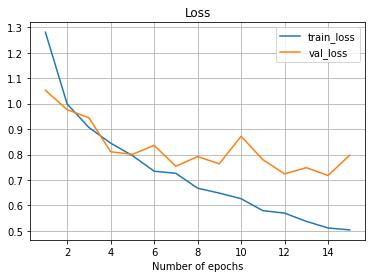

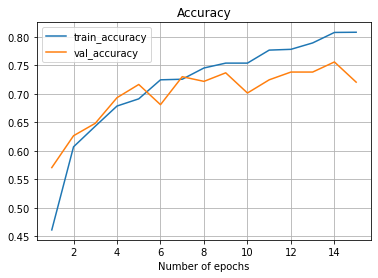

In [33]:
plot_history(history, n_epochs=15)

**Much better results! OVERFITTING HAS BEEN REDUCED!**

## TRY THE NN ON IMAGES FROM DIFFERENT DATASETS

Let's try our model on images from a different set. 

In [34]:
# Download the image
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

In [49]:
# Load the image
w, h = 180, 180
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(w, h)
)
img_array = tf.keras.utils.img_to_array(img)

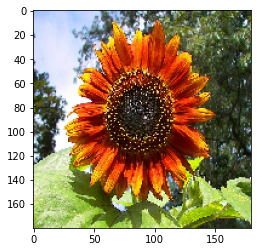

In [46]:
# Display the image
plt.imshow(img_array.astype("uint8"))

In [51]:
# Make the image suitable for the NN
img_array = tf.expand_dims(img_array, 0) # Add batch dimension

# Apply the NN
predicted_categorical_distr = model.predict(img_array)
predicted_categorical_distr = tf.nn.softmax(predicted_categorical_distr)  # We have to apply the softmax after the output 
                                                                          # layer

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predicted_categorical_distr)], 100 * np.max(predicted_categorical_distr))
)

This image most likely belongs to sunflowers with a 99.25 percent confidence.


**Correct!!!**